## Installation

In [244]:
! pip install pandas numpy matplotlib seaborn scipy


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Libraries

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Read the datasets

In [246]:
train=pd.read_csv('../data/raw/training_data.csv')
train.shape

(1460, 81)

# Check for outliers in data

In [247]:
# Function to detect outliers using IQR method and remove them from numeric columns
def remove_outliers_iqr(data):
    cleaned_data = data.copy()  # Create a copy of the original DataFrame
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Numeric columns
    for col in numeric_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2 * IQR
        upper_bound = Q3 + 2 * IQR
        # Remove outliers from the original DataFrame (only for numeric columns)
        cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]
    return cleaned_data

# Remove outliers from numeric columns only, retain all columns in the original DataFrame
cleaned_data = remove_outliers_iqr(train)



In [248]:
print("Train Shape: ",cleaned_data.shape)

Train Shape:  (560, 81)


train has 81 columns (79 features + id and target SalePrice) and 1460 entries
test has 80 columns (79 features + id) and 1459 entries

## CHECK FOR NULL VALUES

In [249]:
print(train.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


<AxesSubplot: >

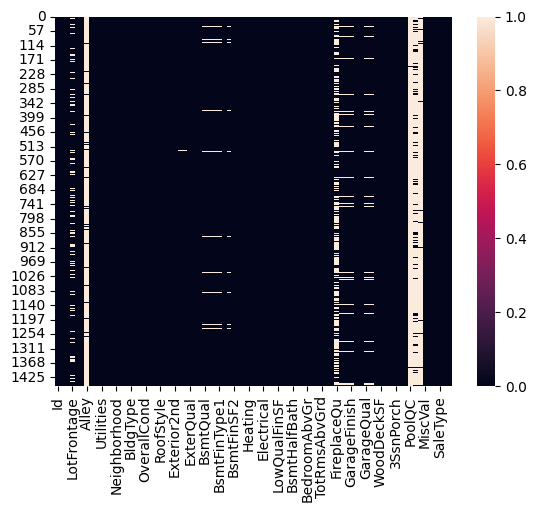

In [250]:
sns.heatmap(train.isnull())

Handling NULL data
We can see that ‘Alley’,’PoolQC’,’Fence’ and ‘MiscFeature’ columns have more than 70% of null values in both train and test data. So, we will drop these columns.
Also, we will drop ‘Id’ column. For non-categorical columns, we will handle null values by filling mean of the column.
For categorical columns, we will handle null values by filling mode of the column.

## Data Imputation

In [251]:
cat_col_train = ['FireplaceQu','GarageType','GarageFinish','MasVnrType','BsmtQual',
           'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
          'GarageQual','GarageCond']

ncat_col_train = ['LotFrontage','GarageYrBlt','MasVnrArea']

for i in cat_col_train:
    train[i] = train[i].fillna(train[i].mode()[0])
    
for j in ncat_col_train:
    train[j] = train[j].fillna(train[j].mean())

## Drop Columns with more missing values

In [252]:
to_drop = ['Id','Alley','PoolQC','Fence','MiscFeature']

for k in to_drop:
    train.drop([k], axis = 1, inplace = True)

<AxesSubplot: >

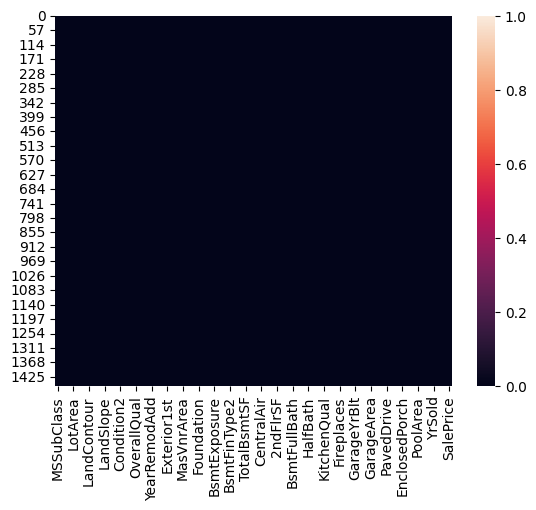

In [253]:
sns.heatmap(train.isnull())

It is observed that for some columns in train data few categories are not present but available in test data. So, we will concat test data to train data, then perform one hot encoding on all categorical columns.

In [254]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500


In [255]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 76, dtype: object

## Check p-values with Categorical features

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


c:\Users\mabbasi4\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


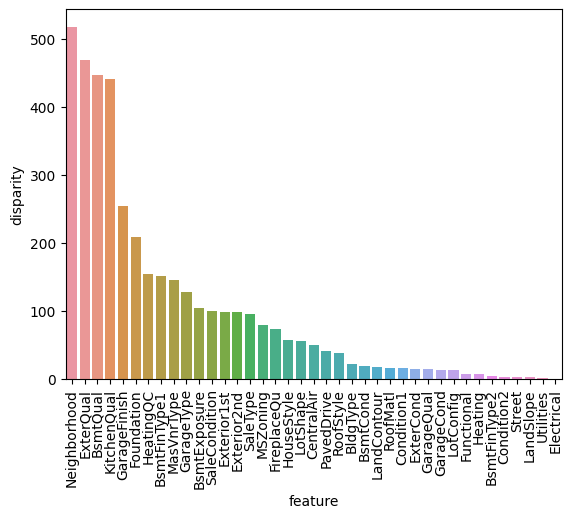

In [256]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

print(qualitative)


def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)
top_20_corr_categorical_features_Anova_features = list (a["feature"].head(25))
 

## Check Correltaion with Numeric Features

In [257]:
def correlated_features(train) :
    
    target_column = 'SalePrice'

    # Compute the correlation matrix between features and the target variable
    correlation_with_target = train.corr()[target_column].abs().sort_values(ascending=False)
    # Set a threshold for selecting highly correlated features
    threshold = 0.1
    # Select features highly correlated with the target variable and get their names as a list
    corr_features = correlation_with_target[correlation_with_target >= threshold].drop(target_column).index.tolist()

    return corr_features


highly_correlated_features = correlated_features(train)


    

C:\Users\mabbasi4\AppData\Local\Temp\ipykernel_9812\223578021.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = train.corr()[target_column].abs().sort_values(ascending=False)


# Feature Selection

In [258]:
final_df = train [top_20_corr_categorical_features_Anova_features + highly_correlated_features + ['SalePrice']]

## One-Hot Encoding

In [259]:

final_df = pd.get_dummies(final_df)
# Example usage to read and display the data
final_df.head(3)


,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl
0,7,1710,2,548,856,856,2,8,2003,2003,...,0,0,0,0,0,1,0,0,0,1
1,6,1262,2,460,1262,1262,2,6,1976,1976,...,0,0,0,0,0,1,0,0,0,1
2,7,1786,2,608,920,920,2,6,2001,2002,...,0,0,0,0,0,1,0,0,0,1


In [260]:
final_df.dtypes

OverallQual        int64
GrLivArea          int64
GarageCars         int64
GarageArea         int64
TotalBsmtSF        int64
                   ...  
BsmtCond_TA        uint8
LandContour_Bnk    uint8
LandContour_HLS    uint8
LandContour_Low    uint8
LandContour_Lvl    uint8
Length: 190, dtype: object

In [261]:
final_df.shape

(1460, 190)

In [262]:
final_df.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl
0,7,1710,2,548,856,856,2,8,2003,2003,...,0,0,0,0,0,1,0,0,0,1
1,6,1262,2,460,1262,1262,2,6,1976,1976,...,0,0,0,0,0,1,0,0,0,1
2,7,1786,2,608,920,920,2,6,2001,2002,...,0,0,0,0,0,1,0,0,0,1
3,7,1717,3,642,756,961,1,7,1915,1970,...,0,0,0,1,0,0,0,0,0,1
4,8,2198,3,836,1145,1145,2,9,2000,2000,...,0,0,0,0,0,1,0,0,0,1


## Saved the Prepocessed data

In [263]:
final_df.to_csv('../data/processed_data/feature_engineered_data.csv')